In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from scripts.merge_cmu import clean_cmu
from scipy import stats
from scripts.category_analysis import *

In [2]:
# Load the dataset merge_imdb
df = pd.read_csv('adapted_movies.csv')
_, cat_df = analysis_by_category(df, '../data/genre_categories.json')

In [3]:
def weighted_ratings(m, rating_nb_df, rating_df):
    C = rating_df.mean()
    return (rating_nb_df/ (rating_nb_df + m)) * rating_df + (m / (rating_nb_df + m)) * C
    

In [4]:
def create_weighted_ratings_df(df): 
    rating_df = pd.DataFrame(df[['MovieRating', 'MovieRatingNb', 'BookRating', 'BookRatingNb', 'MovieRuntime', 'category']])
    rating_df = rating_df[~rating_df.index.duplicated(keep='first')].dropna()

    m_book = rating_df['BookRatingNb'].quantile(0.25)
    rating_df['WeightedBookRating'] = weighted_ratings(m_book, rating_df['BookRatingNb'], rating_df['BookRating'])

    m_movie = rating_df['MovieRatingNb'].quantile(0.25)
    rating_df['WeightedMovieRating'] = weighted_ratings( m_movie, rating_df['MovieRatingNb'], rating_df['MovieRating'])
    
    return rating_df
    

In [5]:
def category_correlation(coef, df, col1, col2): 
    category_stats = {}
    categories= df['category'].unique()

    for category in categories : 
        df_cat = df[df['category'] == category]
        if len(df_cat[col1]) > 2: 
            if coef == 'pearson': 
                res = stats.pearsonr(df_cat[col1], df_cat[col2])
                category_stats[category]= res
            elif coef == 'spearman': 
                res = stats.spearmanr(df_cat[col1], df_cat[col2])
                category_stats[category]= res

    category_stats_df = pd.DataFrame.from_dict(
        category_stats, 
        orient='index', 
        columns=['Correlation', 'P-value']
    ).reset_index()
    category_stats_df.rename(columns={'index': 'Category'}, inplace=True)
    category_stats_df['Significant'] = category_stats_df['P-value'].apply(lambda x : (x < 0.05))
    
    return category_stats_df.sort_values(by=['Correlation']).reset_index()
                

In [6]:
def plot_category_correlation(df, title): 
    plt.figure(figsize=(10, 8))
    sns.barplot(
        data=df,
        y='Category',
        x='Correlation',
        hue='Significant',
        palette={True: 'orange', False: 'grey'},
        dodge=False
    )
    for i, row in df.iterrows():
        plt.text(
            x=row['Correlation'], 
            y=i, 
            s=f"{row['Correlation']:.2f}", 
            va='center', 
            ha='right' if row['Correlation'] < 0 else 'left', 
            color='black', 
            fontsize=10
    )
    
 
    

    plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
    plt.title(f'{title}')
    plt.xlabel('Correlation')
    plt.ylabel('Category')
    plt.legend(title='Significance', loc='upper right')

    plt.tight_layout()
    plt.show()

In [7]:
  """ 
    for i, row in df.iterrows():
        plt.text(
        row['Correlation'],  # X-coordinate
        i,  # Y-coordinate
        f"{row['Correlation']:.2f}",  # Text: rounded correlation value
        va='center',  # Align text vertically
        ha='right' if row['Correlation'] < 0 else 'left',  # Align text based on the value
        color='black'
    )
    """

' \n  for i, row in df.iterrows():\n      plt.text(\n      row[\'Correlation\'],  # X-coordinate\n      i,  # Y-coordinate\n      f"{row[\'Correlation\']:.2f}",  # Text: rounded correlation value\n      va=\'center\',  # Align text vertically\n      ha=\'right\' if row[\'Correlation\'] < 0 else \'left\',  # Align text based on the value\n      color=\'black\'\n  )\n  '

In [8]:
rating_df = create_weighted_ratings_df(cat_df)
rating_df

,MovieRating,MovieRatingNb,BookRating,BookRatingNb,MovieRuntime,category,WeightedBookRating,WeightedMovieRating
0,5.2,78,3.99,348112.0,120.0,Classic & Silent,3.989390,6.438353
1,5.1,636,4.18,17986.0,88.0,Historical & Period,4.147429,6.060202
4,6.0,1100,3.97,1937.0,52.0,Classic & Silent,3.931314,6.281575
5,5.3,540,3.99,348112.0,60.0,Classic & Silent,3.989390,6.165587
8,5.4,589,3.99,348112.0,81.0,Classic & Silent,3.989390,6.174048
...,...,...,...,...,...,...,...,...
2833,7.4,71179,3.81,653.0,120.0,Thrillers & Mysteries,3.880219,7.383309
2836,6.8,2040,4.01,378641.0,122.0,Crime & Gangster,4.009315,6.683787
2837,6.5,1668,4.05,631550.0,150.0,Romance & Relationship,4.049439,6.504222
2838,6.7,2662,3.69,2921.0,117.0,Thrillers & Mysteries,3.783762,6.635567


## Correlation Runtime vs MovieRating (for Weighted and Non Weighted Ratings)
question : Is a longer runtime correlated with a higher movie rating ? We could think that a longer runtime allows to capture a more details of the book, depicting more complex stories thus more appealing for the public. 


### 1) global correlation 

In [9]:
res = stats.pearsonr(rating_df['WeightedMovieRating'], rating_df['MovieRuntime'])
res

PearsonRResult(statistic=0.3017278551773791, pvalue=6.2675757059982325e-37)

In [10]:
res = stats.pearsonr(rating_df['MovieRating'], rating_df['MovieRuntime'])
res

PearsonRResult(statistic=0.3245542301013157, pvalue=8.947122156977859e-43)

In [11]:
res = stats.spearmanr(rating_df['WeightedMovieRating'], rating_df['MovieRuntime'])
res

SignificanceResult(statistic=0.2945651690850731, pvalue=3.3629260224656015e-35)

In [12]:
res = stats.spearmanr(rating_df['MovieRating'], rating_df['MovieRuntime'])
res

SignificanceResult(statistic=0.32827789828531057, pvalue=8.889614388880626e-44)

Both results are significant (pvalue < 0.05). There exists a small but positive correlation between the runtime and its rating. 

### 2. correlation per category

1. Spearman Correlation Weighted

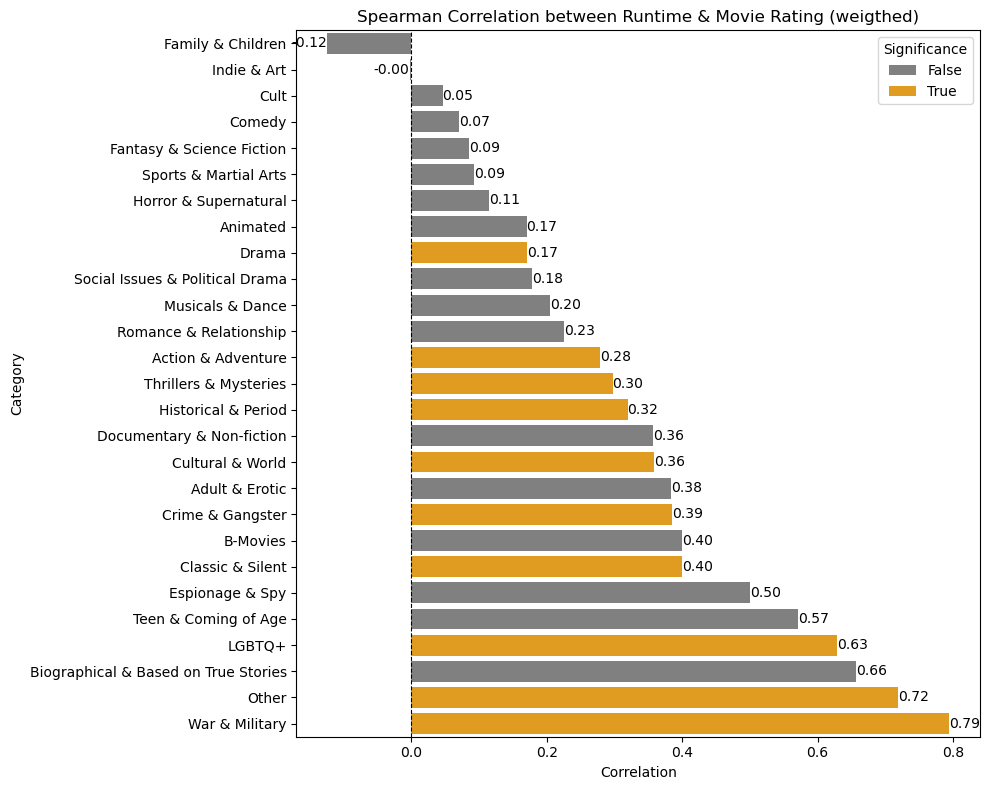

In [13]:
corr_runtime_rating = category_correlation('spearman', rating_df, 'WeightedMovieRating', 'MovieRuntime')
plot_category_correlation(corr_runtime_rating, 'Spearman Correlation between Runtime & Movie Rating (weigthed)')


2) Spearman Correlation Non Weighted

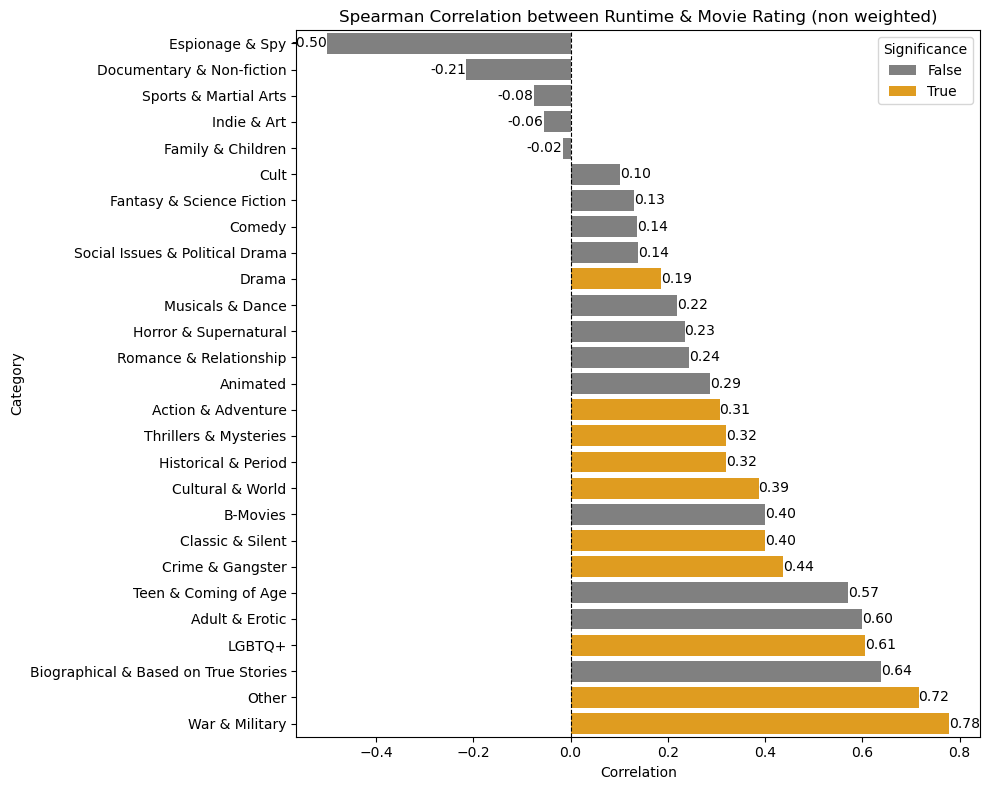

In [14]:
corr_runtime_rating = category_correlation('spearman', rating_df, 'MovieRating', 'MovieRuntime')
plot_category_correlation(corr_runtime_rating, 'Spearman Correlation between Runtime & Movie Rating (non weighted)')

3) Pearson Correlation Weighted

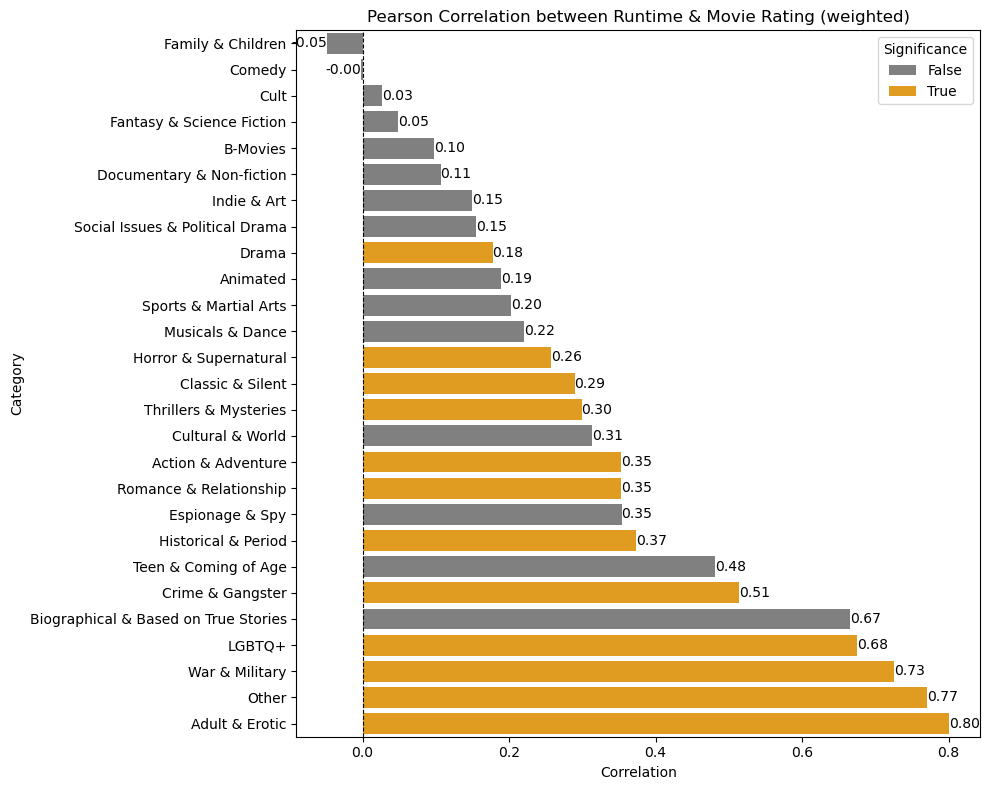

In [15]:
corr_runtime_rating = category_correlation('pearson', rating_df, 'WeightedMovieRating', 'MovieRuntime')
plot_category_correlation(corr_runtime_rating, 'Pearson Correlation between Runtime & Movie Rating (weighted)')

4) Pearson Correlation Non Weighted

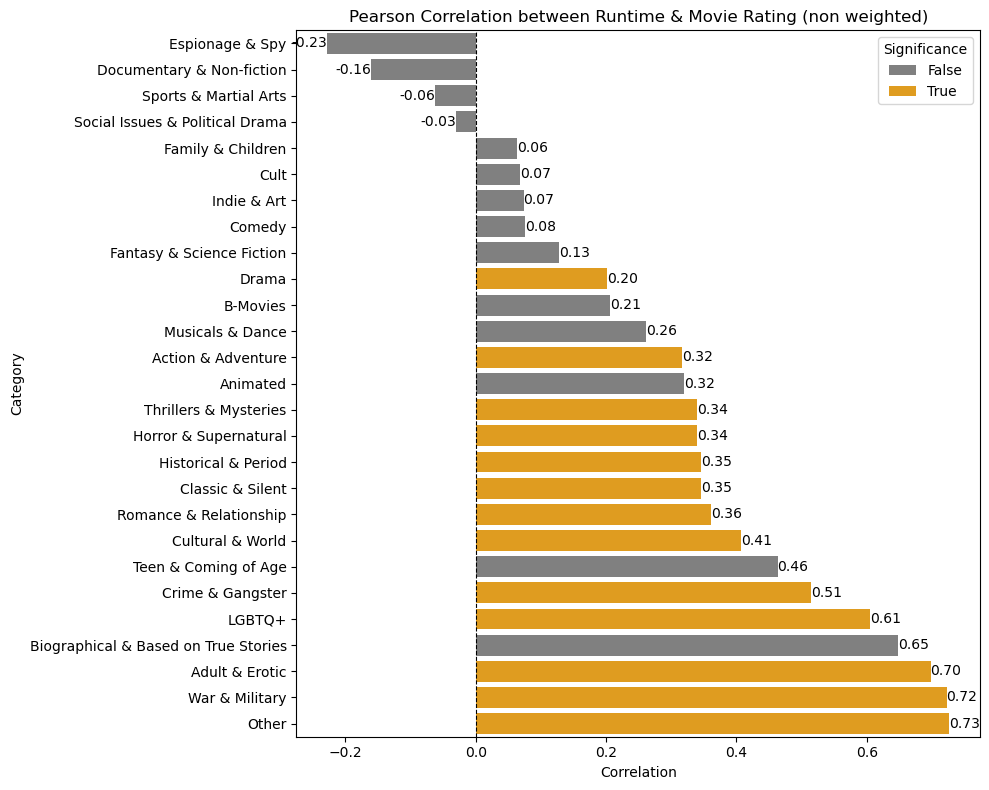

In [16]:
corr_runtime_rating = category_correlation('pearson', rating_df, 'MovieRating', 'MovieRuntime')
plot_category_correlation(corr_runtime_rating, 'Pearson Correlation between Runtime & Movie Rating (non weighted)')

## Correlation BookRating vs MovieRating (for Weighted and Non Weighted 

## 1. global correlation 

In [17]:
res = stats.pearsonr(rating_df['WeightedMovieRating'], rating_df['WeightedBookRating'])
res

PearsonRResult(statistic=0.22845116276604804, pvalue=1.8444817378173633e-21)

In [18]:
res = stats.spearmanr(rating_df['WeightedMovieRating'], rating_df['WeightedBookRating'])
res

SignificanceResult(statistic=0.20707497598765137, pvalue=7.8068959478599e-18)

In [19]:
res = stats.pearsonr(rating_df['MovieRating'], rating_df['BookRating'])
res

PearsonRResult(statistic=0.2091070999938418, pvalue=3.66541955426494e-18)

In [20]:
res = stats.spearmanr(rating_df['MovieRating'], rating_df['BookRating'])
res

SignificanceResult(statistic=0.20493970873102615, pvalue=1.7132694878224367e-17)

## 2. category correlation

1. Spearman Correlation Weighted

In [21]:
corr_book_movie_rating.head()

NameError: name 'corr_book_movie_rating' is not defined

In [ ]:
corr_book_movie_rating = category_correlation('spearman', rating_df, 'WeightedMovieRating', 'WeightedBookRating')
plot_category_correlation(corr_book_movie_rating, 'Spearman Correlation between Book Rating & Movie Rating (weigthed)')

2. Spearman Correlation Non Weigted

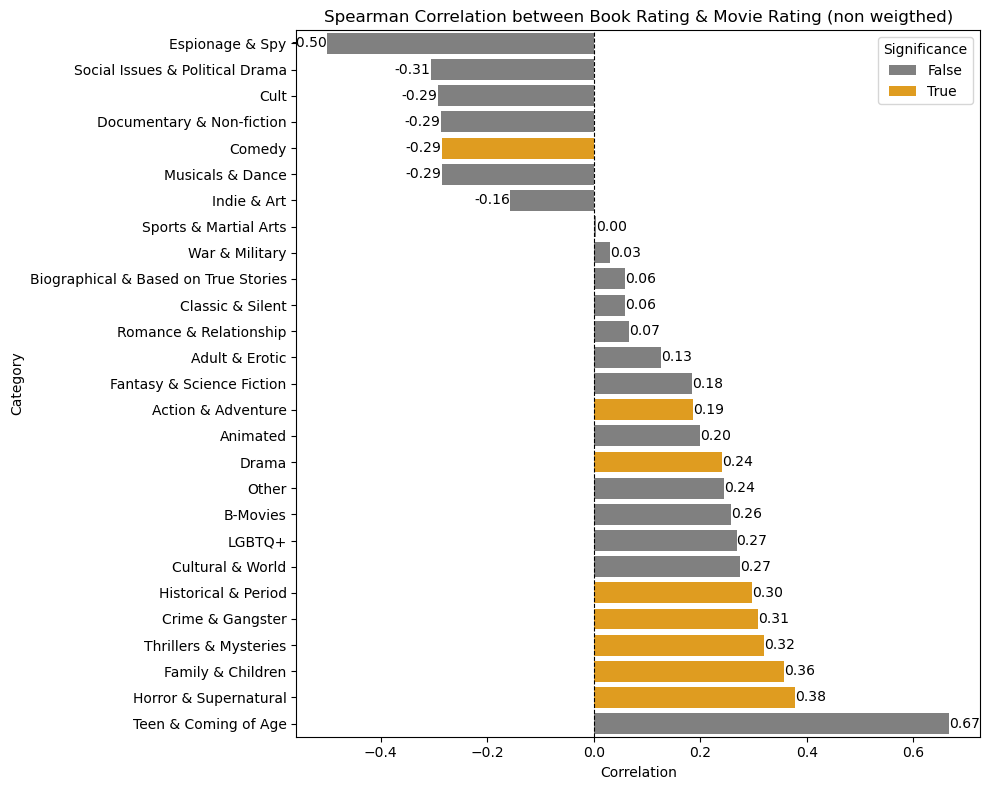

In [22]:
corr_book_movie_rating = category_correlation('spearman', rating_df, 'MovieRating', 'BookRating')
plot_category_correlation(corr_book_movie_rating, 'Spearman Correlation between Book Rating & Movie Rating (non weigthed)')

3. Pearson Correlation Weighted

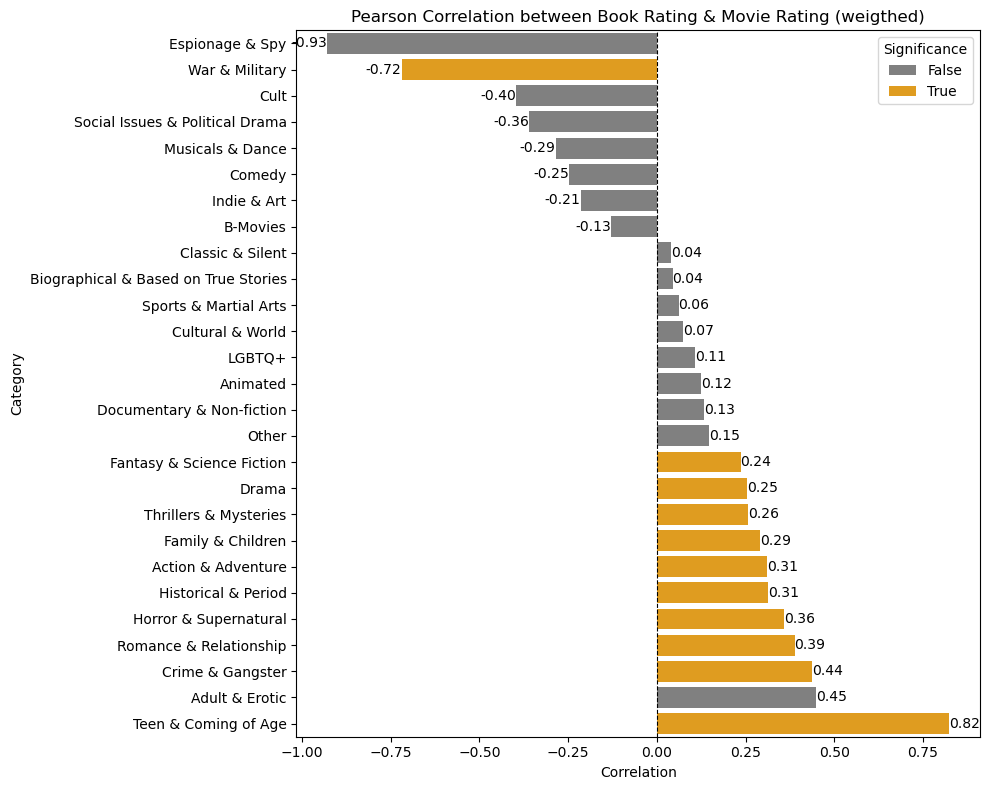

In [23]:
corr_book_movie_rating = category_correlation('pearson', rating_df, 'WeightedMovieRating', 'WeightedBookRating')
plot_category_correlation(corr_book_movie_rating, 'Pearson Correlation between Book Rating & Movie Rating (weigthed)')

4. Pearson Correlation Non Weighted

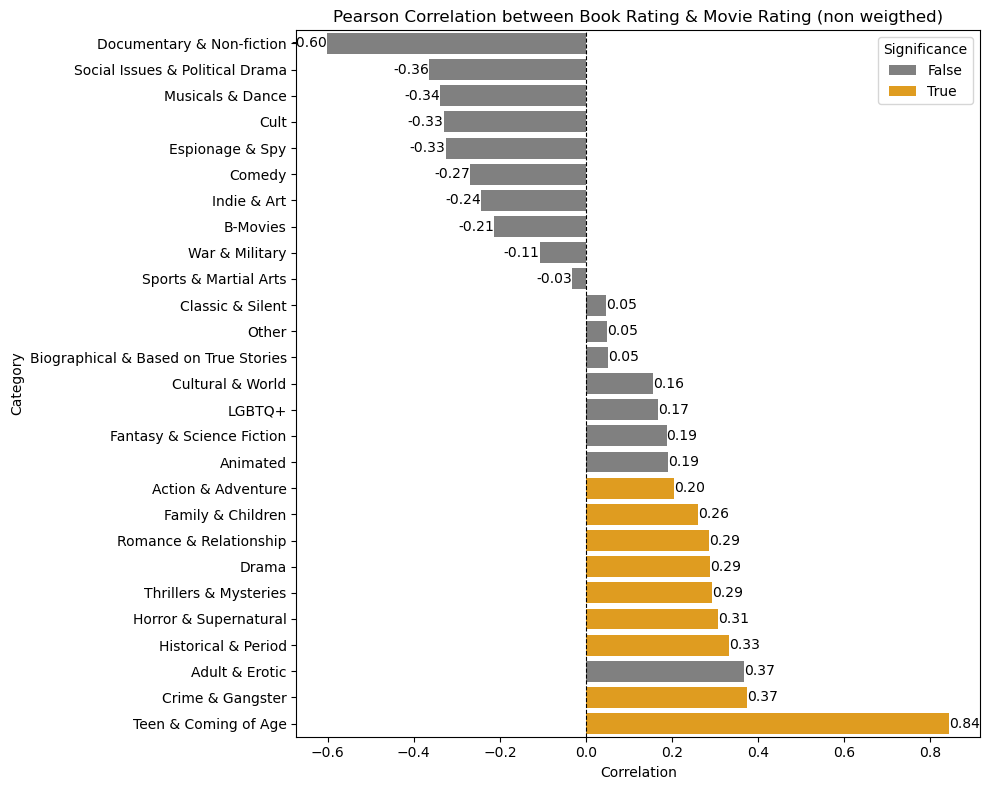

In [24]:
corr_book_movie_rating = category_correlation('pearson', rating_df, 'MovieRating', 'BookRating')
plot_category_correlation(corr_book_movie_rating, 'Pearson Correlation between Book Rating & Movie Rating (non weigthed)')